In [32]:
import numpy as np
import networkx as nx
import sys
import random
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mping
import math

import graph
import ptline
import scenario_builder
import time
import pickle
import copy

import multiprocessing

import pandas as pd

In [33]:
# # Parameters
# debug = True # prints some messages useful to debug
# fast_execution = False
# assign_iterations = 4
# trip_generation_rate = 0.08
# pt_mode_share = 0.124
# walk_speed = 3.5 #Km/h
# v_bus = 30 # km/h
# tau_s = 15/3600 # (in hours) time spent per pickup or dropoff
# tau_T = 180/3600  # (in hours) dwell time. Time that a bus spends doing nothing at the
#                     # end of each cycle
# minimum_headway = 2 # in minutes

# graph_filename = 'montreal_graph.pkl'

## 1. Load data ( Metro lines of Montreal )

In [34]:
#I = mping.imread('.\OpenStreetMap_Montreal.png')
#plt.imshow(I)
#plt.show()

In [35]:
walk_speed = 4.5
g = scenario_builder.build_initial_graph(walk_speed)

In [36]:
all_stations = g.all_stations
all_edges = g.all_edges
centr_id_matr = g.centr_id_matr
acc_matr_init = g.acc_matr

In [37]:
g_lines = nx.DiGraph(list_waiting_time=[], walking_speed=walk_speed)
g_lines.add_nodes_from([i for i in range( len(all_stations) )])
g_lines.add_edges_from(all_edges)

In [38]:
def revert_coordinates(stations, upmost):
    stations_reverted=[]
    for s in stations:
        stations_reverted.append( [s[0],upmost-s[1] ])
    return stations_reverted

In [39]:
from matplotlib.ticker import ScalarFormatter

def plot_heatmap(centr_id_matr, acc_matr, g, all_stations,\
          title, label):

    fig, ax= plt.subplots(figsize=(15, 15))
    im = ax.imshow(acc_matr,cmap = 'OrRd')
    fig.colorbar(im, ax=ax, shrink=0.5, label=label, format=ScalarFormatter())
    ax.set_title(title, fontsize=16)
  
    for i in range(centr_id_matr.shape[0]):
        for j in range(centr_id_matr.shape[1]):
            text = ax.text(j, i, f'{centr_id_matr[i,j]:.0f}',
                           ha="center", va="center", color="w")
    leftmost, rightmost, bottommost, upmost = g.find_limits()
  
    stations_rev = revert_coordinates(all_stations, upmost)
    nx.draw(g_lines, stations_rev, with_labels=False,node_color=g.node_color, node_size = g.node_size)

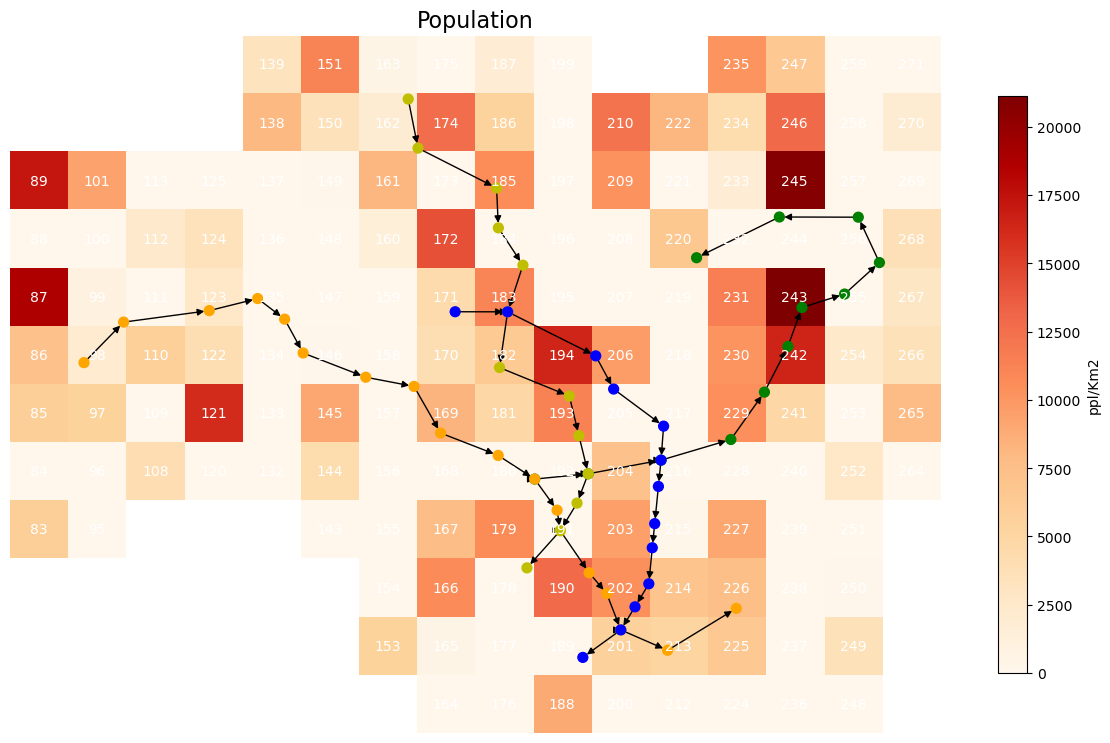

In [40]:
plot_heatmap(centr_id_matr, g.pop_matr, g, all_stations, "Population",\
               "ppl/Km2")

In [41]:
g_lines = nx.DiGraph(list_waiting_time=[], walking_speed=walk_speed)
g_lines.add_nodes_from([i for i in range( len(all_stations) )])
g_lines.add_edges_from(all_edges)

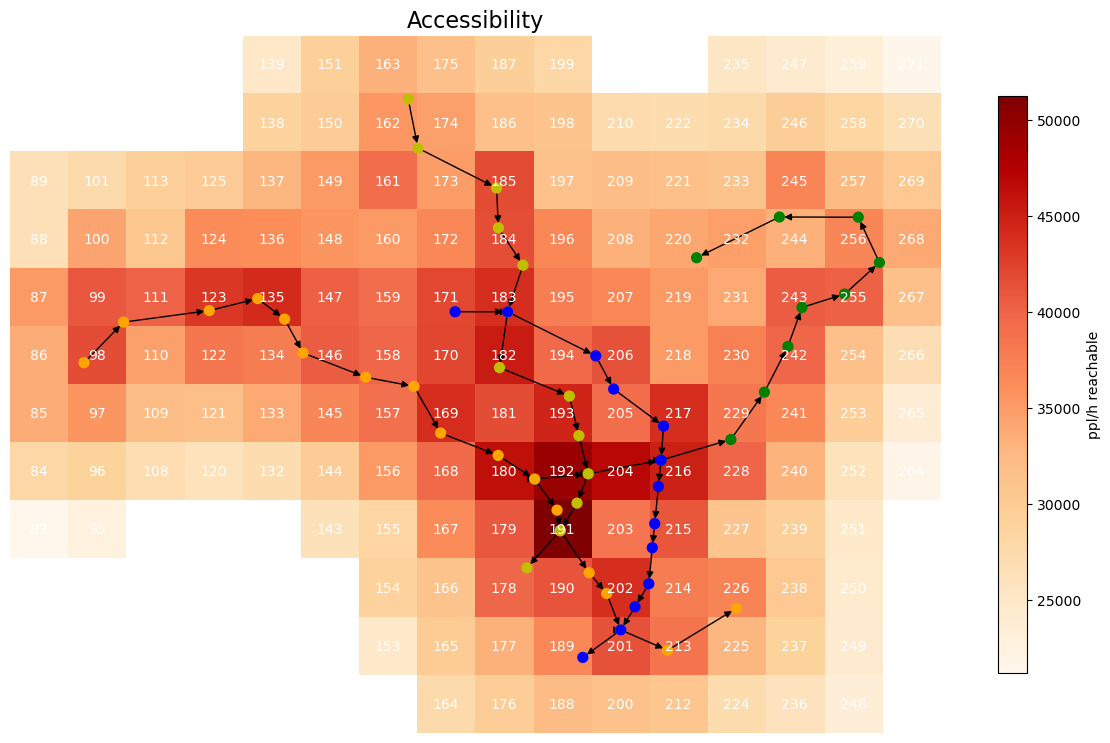

In [42]:
plot_heatmap(centr_id_matr, acc_matr_init, g, all_stations, "Accessibility",\
               "ppl/h reachable")

In [43]:
centroid_population = g.centroid_population
total_population = g.total_population
print(f"total_population={total_population} people")

total_population=604975 people


In [44]:
np.array(g.compute_accessibility()[1]) 

array([21181.97001391, 28062.83842714, 33666.41384908, 33669.89105832,
       35093.45308862, 26436.10475205, 26396.38153299, 22670.26479421,
       28911.72589605, 35488.78810832, 41737.69165522, 40808.65463186,
       34319.05405089, 27498.83727519, 26994.54249117, 32142.3417883 ,
       34593.96271544, 39986.90468682, 30671.72074012, 29353.78859416,
       26075.30897612, 31856.36605893, 38326.29969025, 43095.80272728,
       36445.49071138, 29812.74230706, 27078.22338581, 33921.67184736,
       37728.86883456, 44195.31895294, 36213.96407013, 32918.65491021,
       28777.32353244, 24863.34505563, 26321.52868054, 29820.59938893,
       36861.99832556, 40524.6085787 , 40240.305505  , 35436.46565898,
       35128.05976363, 29802.51405776, 29322.12032625, 24822.13309976,
       28962.65828871, 28156.98011194, 35153.36643846, 38866.25676548,
       39796.81889392, 39240.4886168 , 35053.67493764, 39176.71120972,
       35342.58756315, 33316.40893242, 27488.34027596, 30099.61161976,
      

## 2. DRT allocation function definitions

In [45]:
g.centroid_node

[83,
 84,
 85,
 86,
 87,
 88,
 89,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 108,
 109,
 110,
 111,
 112,
 113,
 120,
 121,
 122,
 123,
 124,
 125,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271]

In [46]:
# All alternative areas
list_area = []
for i in range(80,580):
    if i in g.centroid_node and i+1 in g.centroid_node and i+12 in g.centroid_node and i+13 in g.centroid_node and i+24 in g.centroid_node and i+25 in g.centroid_node:

        list_area_population = [centroid_population[i],
                                centroid_population[i+1],
                                centroid_population[i+12],
                                centroid_population[i+13],
                                centroid_population[i+24],
                                centroid_population[i+25] ]

        if len( [ i for i in list_area_population if i == 0 ] ) <= 2:
            # We only consider areas that contain at most 2 0-population tiles
            list_area.append([i,i+1,i+12,i+13,i+24,i+25])

len(list_area)

# 0 zero population: 206
# 1 zero population: 27
# 2 zero population: 15
# 3 zero population: 3
# 4 zero population: 6
# 5 zero population: 4
# 6 zero population: 2
# 248 = 206 + 27 + 15

47

In [47]:
def find_s1(area,g):
# Find point "s_1" (see the paper) that is the first point visited by the
# DRT bus when it enters the area
    s1 = (g.centroid_to_pos[area[4]] + g.centroid_to_pos[area[5]])/2 + np.array([0.5,0])
    return s1

In [48]:
def findClosestStation(area,g):
    DRT_s_1 = find_s1(area,g)
    distance_station_area_list = []
    for i in g.metro_node:
        metro_pos_i = np.array(g.metro_pos[i])
        distance_station_area_list.append( np.linalg.norm( metro_pos_i - DRT_s_1 ) )

    closest_station = np.argmin( distance_station_area_list )
    return closest_station

In [49]:
def findWorstArea(g):
# Find area with worst Score and its nearest metro station

    alpha = 0.5

    list_acc =  g.compute_accessibility()[1]

    # Get the ranks of centroids related to accessibility and population
    # index_acc_dict: dict{ centroid index -> rank of acc }
    # index_popu_dict: dict{ centroid index -> rank of population }
    index_acc = np.argsort(list_acc)
    index_popu = np.argsort(list(centroid_population.values()))
    index_acc_dict = {}
    index_popu_dict = {}
    for i in range(len(g.centroid_node)):
        index_acc_dict[g.centroid_node[index_acc[i]]] = i
        index_popu_dict[g.centroid_node[index_popu[i]]] = i
    
    
    
    score_list = []
    for area_ in list_area:
        score_ = [] # list of scores of the tiles belonging to area
        for i in area_:
            if centroid_population[i] == 0:
                score_.append(0)
            else:
                # score(c_i) = alpha*population_rank(c_i) + （1-alpha)*(total_nb_centroids - accessibility_rank(c_i) )
                score_.append( alpha*index_popu_dict[i]+ (1-alpha)*(len(g.centroid_node)-index_acc_dict[i]) )
        
            
        score_list.append( np.sum(score_)/len(score_) )

    worst_area = list_area[np.argmax(score_list)]

    # The following line is not strictly needed
    # score_list.sort(reverse=True) 
    

    closest_station = findClosestStation(worst_area,g)

    return [closest_station,worst_area] #[ nearest metro station, worst area ]

In [19]:
from sympy import *

def getHx(n_bus,pho,distance_station_area):
    """
    Solve the system of equations to find the headway of the DRT into an area
    """
    v_bus = 25 #25 km/h
    l = 1      #1 km
    tau_s = 32/3600 #32 s
    tau_T = 60/3600 #60 s
    
    h_x = 0
    cycle_time = 0
    
    h = symbols('h')
    #TODO: for the moment, we assume that the DRT demand is symmetric, i.e.,
    #  the demand out (pax using DRT as first mile) = demand in (pax using DRT in their last mile).
    #  This assumption might not be true and should be removed
    h_x = solve( (2*distance_station_area + 6*l*(pho*l*l*h)/(pho*l*l*h+1)+(pho*l*l*h)*l/3+l*4/3)/v_bus + tau_s*(pho*l*l*h) + tau_T - n_bus*h  , h)

    #TODO: Take the smallest postive solution instead of what we do now
    if len(h_x) == 0:
        print('bug h_x no solution!') #TODO: We should rise an exception instead
    elif len(h_x) == 1:
        hx = float(h_x[0])
    else:
#         print('2 solutions',float(h_x[0]),float(h_x[1]))
        hx = min( float(h_x[0]),float(h_x[1]) )
        if (hx <= 0):
            hx = max( float(h_x[0]),float(h_x[1]) )
    
    pudos = pho*l*l*hx #number of pickups and dropoffs performed by each bus in a cycle
    cycle_time =  n_bus*hx +  tau_T + tau_s*pudos
    
    return hx, cycle_time, pudos

In [20]:
dict_centroid_to_id = {}
for i in range(len(g.centroid_node)):
    dict_centroid_to_id[g.centroid_node[i]] = i
    
tau_T = 60/3600 #60 s

def assignDRT(n_bus,area,g,assign_iterations):
    """
    area: is [list_of_tiles_belonging_to_an_area]
    """
    # Assign n_bus DRT buses to current worst area worst_.
    v_bus = 25 #25 km/h
    metro_station = findClosestStation(area,g)
    
    hx = 0
    cycle_time = 0

    DRT_s_1 = find_s1(area,g)
    metro_station_s_A_pos = np.array(g.metro_pos[metro_station])
    distance_station_area = np.linalg.norm( metro_station_s_A_pos - DRT_s_1 )

    dict_centroid_walk = {}
    for i in area:
        dict_centroid_walk[i] = np.linalg.norm( metro_station_s_A_pos - g.centroid_to_pos[i] )/4.5 #walking speed = 4.5 km/h
    # For the moment we have a maximum limit of assignment iterations because
    # we do all-or-nothing assingment, we in few cases causes the typical
    # instability and we could go on an infinite amount of time
    #TODO: improve traffic assignment
    demand_list_all_steps = []
    centroids_choose_walking = []
    for i in range(assign_iterations):
    # assign_iterations = 4
        print('Assignment iteration',i)
        demand_total = 0.0
        if i < assign_iterations-1:# calculate demand via shortest path
            demand_list = []
            all_pairs_shortest_path_lengths =  dict(nx.all_pairs_dijkstra_path_length(g.g))
            all_pair_shortest_paths = dict(nx.all_pairs_dijkstra_path(g.g) )
            
            #matrix M = {a_ij} a_ij: minimum time from i to j, which is all_pairs_shortest_path_lengths[i][j]
            matrix_pairs_shortest_path_lengths = np.zeros((len(g.centroid_node),len(g.centroid_node))) 

            for j in range( len(g.centroid_node) ):
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[j]
                    des_ = g.centroid_node[k]
                    matrix_pairs_shortest_path_lengths[j][k] = all_pairs_shortest_path_lengths[ori_][des_]

            beta = 0.12

            matrix_pairs_weights = np.exp(-beta*matrix_pairs_shortest_path_lengths).copy()

            for j in range(len(g.centroid_node)):
                matrix_pairs_weights[j][j] = 0


            matrix_pairs_weights = matrix_pairs_weights*np.array(list(g.centroid_POI.values()))

            matrix_pairs_weights = (matrix_pairs_weights.T/np.sum(matrix_pairs_weights, axis=1)).T

            matrix_demand_flow  = (matrix_pairs_weights.T*np.array(list(g.centroid_population.values())) ).T
            
            trip_generation_rate = 0.16
            pt_mode_share = 0.124
            
            matrix_demand_flow  = matrix_demand_flow*trip_generation_rate*pt_mode_share
            

            for tile in area:
                demand_ = 0
                id_tile = dict_centroid_to_id[tile]
                #demand from tile 
                for k in range( len(g.centroid_node) ):
                    des_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[tile][des_]:
                        demand_ = demand_ + matrix_demand_flow[id_tile][k]
                
                #demand to tile        
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[ori_][tile]:
                        demand_ = demand_ + matrix_demand_flow[k][id_tile]
                
                demand_total = demand_total + demand_
                demand_list.append( demand_ )
            print('demand_list',demand_list)
            demand_list_all_steps.append( copy.deepcopy(demand_list) )
                
            #   At this point demand_list contains all the travelers passing by
            #   the stop associated to the area (either walking or using DRT)
 
        else:# the last itearation, calculate demand by taking average of the demands before
            demand_list = list( np.mean( np.array(demand_list_all_steps), axis=0 ) )
            demand_total = np.sum( demand_list )
            

        # At this point, demand_total includes both users using DRT and walking
        hx, cycle_time, pudos = getHx(n_bus,demand_total,distance_station_area)
        print( '0 hx',hx )
        print( '0 cycle_time',cycle_time )
        print( '0 pudos',pudos )

        if hx <= 0:
            continue #need to continue to the next iteration
        else:
            #calculate alpha from demand_list current
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            #update demand_list by comparing time cost of walking and DRT
            centroids_choose_walking = []
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                t_DRT = hx/2 + fraction_of_remaining_cycle*(hx*n_bus - 2*distance_station_area/v_bus- tau_T) + distance_station_area/v_bus
                t_walking = dict_centroid_walk[j]
                if t_walking < t_DRT or demand_list[tile]==0:
                    demand_list[tile] = 0.0
                    centroids_choose_walking.append( j )

            total_area_demand = np.sum(demand_list)
            
            print('total_area_demand',total_area_demand)
            
            if total_area_demand < 20 :
                total_area_demand = demand_total/2
                
            print('total_area_demand_after',total_area_demand)
                
            hx, cycle_time, pudos = getHx(n_bus,total_area_demand,distance_station_area)
            print( '1 hx',hx )
            print( '1 cycle_time',cycle_time )
            print( '1 pudos',pudos )

            
            #update new alpha from new demand_list
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            
            #update ingress/egress time centroid <--> metro station
            t_DRT_dict={}
            for tile in range(len(area)):
                j = area[tile]
                #print('centroid and time',j,  time_alpha*(hx*n_bus-2*distance_station_area/v_bus) + distance_station_area/v_bus)
                if j in centroids_choose_walking:
                    t_walking = dict_centroid_walk[j]
                    g.add_connection( [(j,metro_station, t_walking)] )
                    g.add_connection( [(metro_station,j, t_walking)] )
                else:
                    fraction_of_remaining_cycle = list_1[tile]
                    t_DRT = hx/2+ fraction_of_remaining_cycle*(hx*n_bus-2*distance_station_area/v_bus - tau_T) + distance_station_area/v_bus
                    g.add_connection( [(j,metro_station, t_DRT)] )
                    g.add_connection( [(metro_station,j, t_DRT)] )
                    t_DRT_dict[j] = t_DRT

    return hx, cycle_time

In [21]:
def testHx(n_bus,area,g,assign_iterations):
    """
    area: is [list_of_tiles_belonging_to_an_area]
    """
    # Assign n_bus DRT buses to current worst area worst_.
    v_bus = 25 #25 km/h
    metro_station = findClosestStation(area,g)
    
    hx = 0
    cycle_time = 0

    DRT_s_1 = find_s1(area,g)
    metro_station_s_A_pos = np.array(g.metro_pos[metro_station])
    distance_station_area = np.linalg.norm( metro_station_s_A_pos - DRT_s_1 )

    dict_centroid_walk = {}
    for i in area:
        dict_centroid_walk[i] = np.linalg.norm( metro_station_s_A_pos - g.centroid_to_pos[i] )/4.5 #walking speed = 4.5 km/h
    # For the moment we have a maximum limit of assignment iterations because
    # we do all-or-nothing assingment, we in few cases causes the typical
    # instability and we could go on an infinite amount of time
    #TODO: improve traffic assignment
    demand_list_all_steps = []
    centroids_choose_walking = []
    for i in range(assign_iterations):
    # assign_iterations = 4
        #print('Assignment iteration',i)
        demand_total = 0.0
        if i < assign_iterations-1:# calculate demand via shortest path
            demand_list = []
            all_pairs_shortest_path_lengths =  dict(nx.all_pairs_dijkstra_path_length(g.g))
            all_pair_shortest_paths = dict(nx.all_pairs_dijkstra_path(g.g) )
            
            #matrix M = {a_ij} a_ij: minimum time from i to j, which is all_pairs_shortest_path_lengths[i][j]
            matrix_pairs_shortest_path_lengths = np.zeros((len(g.centroid_node),len(g.centroid_node))) 

            for j in range( len(g.centroid_node) ):
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[j]
                    des_ = g.centroid_node[k]
                    matrix_pairs_shortest_path_lengths[j][k] = all_pairs_shortest_path_lengths[ori_][des_]

            beta = 0.12

            matrix_pairs_weights = np.exp(-beta*matrix_pairs_shortest_path_lengths).copy()

            for j in range(len(g.centroid_node)):
                matrix_pairs_weights[j][j] = 0


            matrix_pairs_weights = matrix_pairs_weights*np.array(list(g.centroid_POI.values()))

            matrix_pairs_weights = (matrix_pairs_weights.T/np.sum(matrix_pairs_weights, axis=1)).T

            matrix_demand_flow  = (matrix_pairs_weights.T*np.array(list(g.centroid_population.values())) ).T
            
            trip_generation_rate = 0.16
            pt_mode_share = 0.124
            
            matrix_demand_flow  = matrix_demand_flow*trip_generation_rate*pt_mode_share
            

            for tile in area:
                demand_ = 0
                id_tile = dict_centroid_to_id[tile]
                #demand from tile 
                for k in range( len(g.centroid_node) ):
                    des_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[tile][des_]:
                        demand_ = demand_ + matrix_demand_flow[id_tile][k]
                
                #demand to tile        
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[ori_][tile]:
                        demand_ = demand_ + matrix_demand_flow[k][id_tile]
                
                demand_total = demand_total + demand_
                demand_list.append( demand_ )
            demand_list_all_steps.append( copy.deepcopy(demand_list) )

            #   At this point demand_list contains all the travelers passing by
            #   the stop associated to the area (either walking or using DRT)
 
        else:# the last itearation, calculate demand by taking average of the demands before
            #print('demand_list_all_steps',demand_list_all_steps)
            demand_list = list( np.mean( np.array(demand_list_all_steps), axis=0 ) )
            demand_total = np.sum( demand_list )
            

        # At this point, demand_total includes both users using DRT and walking
        hx, cycle_time, pudos = getHx(n_bus,demand_total,distance_station_area)
        

        if hx <= 0:
            print('hx_0',hx)
            return 0 
        else:
            #calculate alpha from demand_list current
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            #update demand_list by comparing time cost of walking and DRT
            centroids_choose_walking = []
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                t_DRT = hx/2 + fraction_of_remaining_cycle*(hx*n_bus - 2*distance_station_area/v_bus- tau_T) + distance_station_area/v_bus
                t_walking = dict_centroid_walk[j]
                if t_walking < t_DRT or demand_list[tile]==0:
                    demand_list[tile] = 0.0
                    centroids_choose_walking.append( j )

            total_area_demand = np.sum(demand_list)
            
            #print('total_area_demand',total_area_demand)
            
            if total_area_demand <= 2 :
                print('total_area_demand',total_area_demand)
                return 0
                
            #print('total_area_demand_after',total_area_demand)
                
            hx, cycle_time, pudos = getHx(n_bus,total_area_demand,distance_station_area)

            if hx <= 0:
                print('hx_1',hx)
                return 0 
            
            #update new alpha from new demand_list
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            
            #update ingress/egress time centroid <--> metro station
            t_DRT_dict={}
            for tile in range(len(area)):
                j = area[tile]
                #print('centroid and time',j,  time_alpha*(hx*n_bus-2*distance_station_area/v_bus) + distance_station_area/v_bus)
                if j in centroids_choose_walking:
                    t_walking = dict_centroid_walk[j]
                    g.add_connection( [(j,metro_station, t_walking)] )
                    g.add_connection( [(metro_station,j, t_walking)] )
                else:
                    fraction_of_remaining_cycle = list_1[tile]
                    t_DRT = hx/2+ fraction_of_remaining_cycle*(hx*n_bus-2*distance_station_area/v_bus - tau_T) + distance_station_area/v_bus
                    g.add_connection( [(j,metro_station, t_DRT)] )
                    g.add_connection( [(metro_station,j, t_DRT)] )
                    t_DRT_dict[j] = t_DRT
            
    return 1

In [22]:
import time
t_0 = time.time()

In [23]:
### MAIN PROCEDURE

list_opt_acc = {}


dict_worst_station_area = {}
n_bus = 200
steps = int(n_bus/5)

list_step_worst_area = []
list_step_worst_area_acc = []
list_step_worst_area_popul = []

for i in range(steps):
    print('Step',i,':')
    print('time cost:', time.time()-t_0)
    worst_ = findWorstArea(g)
    print('    Current worst area',worst_[1],' and metro station nearest:',worst_[0])
    print('    Accessibility before',[g.centroid_to_acc[p] for p in worst_[1]] )
    
    list_step_worst_area.append(worst_[1])
    list_step_worst_area_acc.append( [g.centroid_to_acc[p] for p in worst_[1]] )
    list_step_worst_area_popul.append( [g.centroid_population[p] for p in worst_[1]] )
    
    
    metro_station = worst_[0]
    first_centroid = worst_[1][0] #1st centroid of the area
    if (metro_station,first_centroid) in dict_worst_station_area.keys():
        # we already previously added DRT buses to this area. We just increase by 10

        dict_worst_station_area[ (metro_station,first_centroid) ] = dict_worst_station_area[ (worst_[0],worst_[1][0]) ] + 5
    else:
        dict_worst_station_area[ (metro_station,first_centroid) ] = 5

    print('    DRT allocation:')
    for key,value in dict_worst_station_area.items():
        print('        Metro station and 1st centroid {key} -> {value} buses'.format(key = key, value = value))

    if testHx(dict_worst_station_area[ (worst_[0],worst_[1][0]) ],worst_[1],copy.deepcopy(g),4) == 0:
        print('    Nb of buses too small for (station, area) {key}  -----> Not change'.format(key = (worst_) ) )
        print('--------------------------------------------------------------------------')

        # To keep historical data, we save our intermediary results every 1 steps
        list_opt_acc[i+1] =  g.compute_accessibility()[2] 


        continue # This "continue" is useless
    else:
        DRT_buses_currently_deployed_in_the_area = dict_worst_station_area[ (metro_station,first_centroid) ]
        assignDRT(DRT_buses_currently_deployed_in_the_area, worst_[1], g, 4)
        ooo = g.compute_accessibility()
        print('    Acc after',[g.centroid_to_acc[p] for p in worst_[1]] )
        print('----------------------------------------------------------------')

        list_opt_acc[i+1] =  g.compute_accessibility()[2]

Step 0 :
time cost: 0.013535261154174805
    Current worst area [138, 139, 150, 151, 162, 163]  and metro station nearest: 30
    Accessibility before [28777.323532443803, 24863.345055627786, 29802.514057758504, 29322.120326245567, 35342.58756314963, 33316.408932415135]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 5 buses
hx_0 -0.0005224339089994465
    Nb of buses too small for (station, area) [30, [138, 139, 150, 151, 162, 163]]  -----> Not change
--------------------------------------------------------------------------
Step 1 :
time cost: 3.3851006031036377
    Current worst area [138, 139, 150, 151, 162, 163]  and metro station nearest: 30
    Accessibility before [28777.323532443803, 24863.345055627786, 29802.514057758504, 29322.120326245567, 35342.58756314963, 33316.408932415135]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 10 buses
hx_0 -0.0005348757672189756
    Nb of buses too small for (station, area) [30, [138, 139, 150,

Step 12 :
time cost: 54.16374707221985
    Current worst area [209, 210, 221, 222, 233, 234]  and metro station nearest: 10
    Accessibility before [32332.63011331411, 27486.45193405227, 31827.575057027632, 27348.658307963124, 31356.234605157984, 27695.41965664026]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 35 buses
        Metro station and 1st centroid (10, 209) -> 30 buses
total_area_demand 0.0
    Nb of buses too small for (station, area) [10, [209, 210, 221, 222, 233, 234]]  -----> Not change
--------------------------------------------------------------------------
Step 13 :
time cost: 59.64646577835083
    Current worst area [209, 210, 221, 222, 233, 234]  and metro station nearest: 10
    Accessibility before [32332.63011331411, 27486.45193405227, 31827.575057027632, 27348.658307963124, 31356.234605157984, 27695.41965664026]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 35 buses
        Metro station and 1st centroid (10, 

0 hx 0.008866789144844763
0 cycle_time 0.5200942552048012
0 pudos 6.7599147707883445
total_area_demand 612.4527175925659
total_area_demand_after 612.4527175925659
1 hx 0.00775816406505225
1 cycle_time 0.4468105024985702
1 pudos 4.751508665170239
    Acc after [33343.2073217879, 29062.38968473286, 33823.12145538194, 30906.787643194104, 40040.345466007304, 36210.4687344003]
----------------------------------------------------------------
Step 17 :
time cost: 100.95666885375977
    Current worst area [138, 139, 150, 151, 162, 163]  and metro station nearest: 30
    Accessibility before [33343.2073217879, 29062.38968473286, 33823.12145538194, 30906.787643194104, 40040.345466007304, 36210.4687344003]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 55 buses
        Metro station and 1st centroid (10, 209) -> 35 buses
Assignment iteration 0
demand_list [102.99019114573724, 43.87081257964107, 270.8029270605137, 139.2495813389846, 204.3503541010698, 10.683565279107915]
0

total_area_demand 0.0
    Nb of buses too small for (station, area) [9, [221, 222, 233, 234, 245, 246]]  -----> Not change
--------------------------------------------------------------------------
Step 25 :
time cost: 140.78859782218933
    Current worst area [221, 222, 233, 234, 245, 246]  and metro station nearest: 9
    Accessibility before [35203.45238195605, 29174.751016480383, 36333.50695353122, 29501.073097254888, 37110.60656286476, 29755.206130494676]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 60 buses
        Metro station and 1st centroid (10, 209) -> 35 buses
        Metro station and 1st centroid (9, 221) -> 35 buses
Assignment iteration 0
demand_list [36.374762883393174, 149.29904856449372, 250.8232775877911, 175.5519818614473, 316.22330217187414, 197.0323579790785]
0 hx 0.040698365083477156
0 cycle_time 1.8482033359160002
0 pudos 45.79806277435875
total_area_demand 316.22330217187414
total_area_demand_after 316.22330217187414
1 hx 0.013049107

0 hx 0.005338444689033458
0 cycle_time 0.42839856602103266
0 pudos 4.27958675122769
total_area_demand 790.1304178254034
total_area_demand_after 790.1304178254034
1 hx 0.005296557807070678
1 cycle_time 0.4246254592339444
1 pudos 4.184971433137157
    Acc after [35285.337040551596, 31158.963465786983, 35226.70934441083, 31099.171401228086, 40792.36159329345, 36359.70889712546]
----------------------------------------------------------------
Step 29 :
time cost: 182.72912096977234
    Current worst area [209, 210, 221, 222, 233, 234]  and metro station nearest: 10
    Accessibility before [35397.54479318067, 30082.821346100736, 36119.138399032796, 29450.075693992218, 37196.677329749495, 29860.684164755996]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 70 buses
        Metro station and 1st centroid (10, 209) -> 45 buses
        Metro station and 1st centroid (9, 221) -> 35 buses
Assignment iteration 0
demand_list [135.14445738296055, 185.28421313328246, 38.091906

1 hx 0.004378659316669992
1 cycle_time 0.3985422609996007
1 pudos 3.553070512425151
    Acc after [35751.32266763499, 31686.58950043997, 35668.66224679753, 31552.25101023246, 41185.3217350419, 36460.30863298391]
----------------------------------------------------------------
Step 33 :
time cost: 224.53781986236572
    Current worst area [209, 210, 221, 222, 233, 234]  and metro station nearest: 10
    Accessibility before [36132.95038095362, 30800.50898546626, 36871.545211347955, 30739.451214517052, 37861.908559334945, 30124.042281308073]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 80 buses
        Metro station and 1st centroid (10, 209) -> 50 buses
        Metro station and 1st centroid (9, 221) -> 40 buses
Assignment iteration 0
demand_list [140.76955095649595, 190.1772891309499, 38.191799594175336, 5.8584319465590475, 274.11092057913817, 191.38778425976352]
0 hx 0.012143496945132762
0 cycle_time 0.7145664729804159
0 pudos 10.206557893924998
total_area_d

0 hx 0.0037523362250239884
0 cycle_time 0.38274568506390433
0 pudos 3.1914852913213565
total_area_demand 838.5744603538557
total_area_demand_after 838.5744603538557
1 hx 0.0037252071383002267
1 cycle_time 0.3797029852532999
1 pudos 3.1238635657064435
    Acc after [36379.67422089934, 32328.609414857703, 36267.85326836668, 31999.593825262466, 41701.10634535153, 36619.53101241826]
----------------------------------------------------------------
Step 37 :
time cost: 267.22067403793335
    Current worst area [209, 210, 221, 222, 233, 234]  and metro station nearest: 10
    Accessibility before [36667.7529320617, 31328.96816525112, 37318.20902256359, 30775.56508653298, 38345.74913214637, 30314.987985525047]
    DRT allocation:
        Metro station and 1st centroid (30, 138) -> 90 buses
        Metro station and 1st centroid (10, 209) -> 60 buses
        Metro station and 1st centroid (9, 221) -> 40 buses
Assignment iteration 0
demand_list [140.96145562064922, 200.67788730449823, 40.2939704

In [24]:
list_opt_acc

{1: 0.015186770135092509,
 2: 0.015186770135092509,
 3: 0.015186770135092509,
 4: 0.015186770135092509,
 5: 0.015186770135092509,
 6: 0.015186770135092509,
 7: 0.014865486225254854,
 8: 0.014865486225254854,
 9: 0.014865486225254854,
 10: 0.014865486225254854,
 11: 0.014865486225254854,
 12: 0.014865486225254854,
 13: 0.014865486225254854,
 14: 0.014186234208932724,
 15: 0.014106520675862155,
 16: 0.014090749933219238,
 17: 0.014079620589039887,
 18: 0.014075212893343236,
 19: 0.01407378808800308,
 20: 0.01407378808800308,
 21: 0.01407378808800308,
 22: 0.01407378808800308,
 23: 0.01407378808800308,
 24: 0.01407378808800308,
 25: 0.01407378808800308,
 26: 0.014011460779393636,
 27: 0.014008780713779534,
 28: 0.013970215422545618,
 29: 0.013955353832901252,
 30: 0.01386920306637729,
 31: 0.01385391432361538,
 32: 0.013830899317323841,
 33: 0.013817495576326944,
 34: 0.013809078894140958,
 35: 0.013775681917275184,
 36: 0.013764297500805767,
 37: 0.013757219902453488,
 38: 0.013727367975

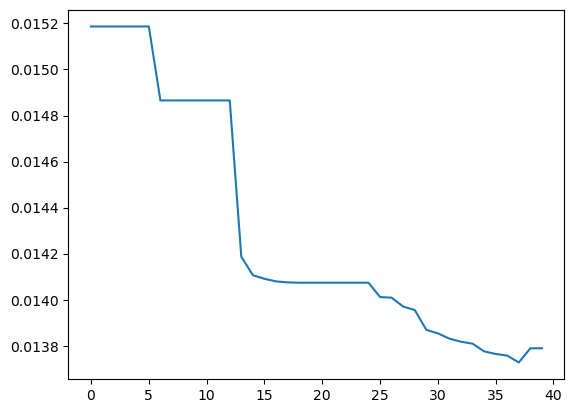

In [25]:
plt.plot( list_opt_acc.values() )

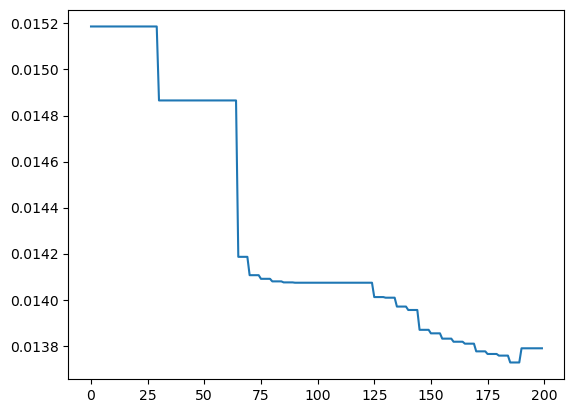

In [31]:
list_opt_acc_per_bus = []
for i in range(len(list_opt_acc.values())):
    for j in range(5):
        list_opt_acc_per_bus.append( list(list_opt_acc.values()).copy()[i])

plt.plot( list_opt_acc_per_bus )

In [26]:
np.reshape(np.array(list_step_worst_area),-1)

array([138, 139, 150, 151, 162, 163, 138, 139, 150, 151, 162, 163, 138,
       139, 150, 151, 162, 163, 138, 139, 150, 151, 162, 163, 138, 139,
       150, 151, 162, 163, 138, 139, 150, 151, 162, 163, 138, 139, 150,
       151, 162, 163, 209, 210, 221, 222, 233, 234, 209, 210, 221, 222,
       233, 234, 209, 210, 221, 222, 233, 234, 209, 210, 221, 222, 233,
       234, 209, 210, 221, 222, 233, 234, 209, 210, 221, 222, 233, 234,
       209, 210, 221, 222, 233, 234, 138, 139, 150, 151, 162, 163, 138,
       139, 150, 151, 162, 163, 138, 139, 150, 151, 162, 163, 138, 139,
       150, 151, 162, 163, 138, 139, 150, 151, 162, 163, 221, 222, 233,
       234, 245, 246, 221, 222, 233, 234, 245, 246, 221, 222, 233, 234,
       245, 246, 221, 222, 233, 234, 245, 246, 221, 222, 233, 234, 245,
       246, 221, 222, 233, 234, 245, 246, 221, 222, 233, 234, 245, 246,
       138, 139, 150, 151, 162, 163, 209, 210, 221, 222, 233, 234, 138,
       139, 150, 151, 162, 163, 209, 210, 221, 222, 233, 234, 13

In [51]:
np.save( 'list_opt_acc_per_bus_alpha50.npy',  np.array(list_opt_acc_per_bus)   )

In [52]:
#np.save( 'list_step_worst_area_alpha50.npy',  np.reshape(np.array(list_step_worst_area),-1)  )

Text(0, 0.5, 'population')

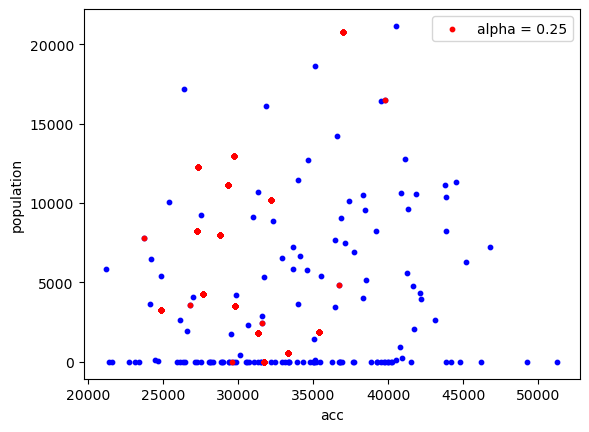

In [50]:
plt.scatter( g.centroid_to_acc.values() ,  g.centroid_population.values(), s=10,c='b')

x_acc = []
y_popul = []
for i in np.reshape(np.array(list_step_worst_area),-1):
    x_acc.append( g.centroid_to_acc[i] )
    y_popul.append( g.centroid_population[i] )
plt.scatter( x_acc ,  y_popul, s=10,c='r',label = 'alpha = 0.25')
plt.legend()

plt.xlabel('acc')
plt.ylabel('population')

In [30]:
@@@@@

SyntaxError: invalid syntax (2703290252.py, line 1)

In [ ]:
0.09345986012697999*60

In [ ]:
1.381253317356044*60

In [ ]:
DRT allocation:
    Metro station and 1st centroid (0, 340) -> 17 buses
    1 hx 0.053339342329664204
    1 cycle_time 1.0949161327322778
    1 pudos 19.29157272689846
    
    Metro station and 1st centroid (28, 96) -> 17 buses
    1 hx 0.05020370395354467
    1 cycle_time 1.0373212026071847
    1 pudos 18.809051482154096
    
    Metro station and 1st centroid (28, 112) -> 17 buses
    1 hx 0.05630799446245635
    1 cycle_time 1.1555686860180892
    1 pudos 20.437437767587255
    
    Metro station and 1st centroid (26, 538) -> 10 buses
    1 hx 0.09356816343375637
    1 cycle_time 1.1115138434535594
    1 pudos 17.906123525549503
    
    Metro station and 1st centroid (61, 225) -> 7 buses
    1 hx 0.10359069053374577
    1 cycle_time 0.8481627009155188
    1 pudos 11.965635057671074
    
    Metro station and 1st centroid (21, 514) -> 26 buses
    1 hx 0.053565821954746434
    1 cycle_time 1.7379234055489072
    1 pudos 36.96135390661874
    
    Metro station and 1st centroid (72, 376) -> 22 buses
    1 hx 0.04720666807306283
    1 cycle_time 1.2611298408098979
    1 pudos 23.165603610283018
    
    Metro station and 1st centroid (56, 148) -> 14 buses
    1 hx 0.050417382283606364
    1 cycle_time 0.857482166496775
    1 pudos 15.18436663420716
    
    Metro station and 1st centroid (29, 156) -> 17 buses
    1 hx 0.05454417929859241
    1 cycle_time 1.1374769540856422
    1 pudos 21.775414426076743
    
    Metro station and 1st centroid (24, 457) -> 8 buses
    1 hx 0.061702039993180864
    1 cycle_time 0.5836501141616189
    1 pudos 8.25380184931935
    
    Metro station and 1st centroid (33, 275) -> 12 buses
    1 hx 0.09345986012697999
    1 cycle_time 1.381253317356044
    1 pudos 27.34518703113196
    
    Metro station and 1st centroid (5, 464) -> 4 buses
    no change

In [ ]:
plot_heatmap(centr_id_matr, acc_matr_init, g, all_stations, "Accessibility",\
               "ppl/h reachable")

In [ ]:
centr_id_matr_final, acc_matr_final = g.build_accessibility_matrix()

In [ ]:
plot_heatmap(centr_id_matr_final, acc_matr_final, g, all_stations, "Accessibility",\
               "ppl/h reachable")

In [ ]:
plot_heatmap(centr_id_matr, acc_matr_final-acc_matr_init, g, all_stations, "Accessibility",\
               "ppl/h reachable")

In [ ]:
3068/170

In [ ]:
t_1 = time.time()
print(t_1-t_0)

In [ ]:
# We print the history of the optimization
# list_opt_acc is a dictionary of {(DRT used in total, [list of acc. of all tiles])}
list_opt_acc.keys()

In [ ]:
len(list_opt_acc[1])

In [ ]:
def findex(list_in):
    
    list_x = []
    
    for i in range(332):
        polu_ = math.ceil( list(centroid_population.values())[i] )
        for j in range(polu_):
            list_x.append( list_in[i] )
    
    
    list_x = np.array(list_x)
    list_x.sort()
    y_mean = np.mean( list_x )   
    
    
    p = math.ceil(len(list_x)/10)
    
    #atkinson
    sum_ = 0.
    for i in range( len(list_x) ):
        sum_ = sum_ + list_x[i]**(-1) 
    sum_ = 1 - (sum_/len(list_x))**(-1)/y_mean
    
#     #theil
#     sum_T = 0.
#     for i in range( len(list_x) ):
#         sum_T = sum_T +  list_x[i]/y_mean*np.log( list_x[i]/y_mean )
#     sum_T = sum_T/len(list_x)
    
#     #petral
#     sum_P = 0.
#     for i in range( len(list_x) ):
#         sum_P = sum_P +  np.abs(list_x[i]-y_mean)/y_mean
#     sum_P = sum_P/(2* len(list_x) )
    
#     #palma
#     sum_palma = np.sum(list_x[-p:])/np.sum(list_x[:4*p])
    
    
    return [np.mean(list_x[:p]),np.mean(list_x),sum_]

In [ ]:
res_opt_list = []
for i in list(list_opt_acc.keys()):
# for i in [1,170]:
    res_opt_list.append(findex( list_opt_acc[i] ))

In [ ]:
np.shape( res_opt_list )

In [ ]:
res_opt_list[0]

In [ ]:
res_opt_list[249]

In [ ]:
(res_opt_list[249][0] - res_opt_list[0][0])/res_opt_list[0][0]

In [ ]:
(res_opt_list[249][1] - res_opt_list[0][1])/res_opt_list[0][1]

## 3.Results

In [ ]:
Opt_acc_polulation = np.array( res_opt_list.copy() )

In [ ]:
Initial_ = np.array(res_opt_list.copy()[0])

In [ ]:
Initial_

In [ ]:
x = np.array([i+1 for i in range(250)])

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(x,Opt_acc_polulation[:,0],color='black',label = 'AccEq-DRT')
# plt.plot(x,Random_acc_polulation[:,0],color='grey',label = 'Baseline')
plt.plot(x,np.array([Initial_[0] for i in range(len(x))]),color='black',label = 'Initial',linestyle='--')
plt.xlabel('Fleet size $N$')
plt.ylabel('10% worst avg. Accessibility')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 25})
plt.savefig("Fig4.jpg",dpi=600)
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(x,Opt_acc_polulation[:,1],color='black',label = 'AccEq-DRT')
# plt.plot(x,Random_acc_polulation[:,1],color='grey',label = 'Baseline')
plt.plot(x,np.array([Initial_[1] for i in range(len(x))]),color='black',label = 'Initial',linestyle='--')
plt.xlabel('Fleet size $N$')
plt.ylabel('Avg. Accessibility')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 25})
plt.savefig("Fig5.jpg",dpi=600)
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(x,Opt_acc_polulation[:,2],color='black',label = 'AccEq-DRT')
# plt.plot(x,Random_acc_polulation[:,2],color='grey',label = 'Baseline')
plt.plot(x,np.array([Initial_[2] for i in range(len(x))]),color='black',label = 'Initial',linestyle='--')
plt.legend(loc='best')
plt.xlabel('Fleet size $N$')
plt.ylabel('Atkinson')
plt.rcParams.update({'font.size': 25})
plt.savefig("Fig6.jpg",dpi=600)
plt.show()

In [ ]:
# np.save( 'Opt_acc_polulation_25.npy',Opt_acc_polulation )

In [ ]:
@

## 3. Analyze results

In [ ]:
DRT allocation:
    Bus stop 28  [] -> 210 buses          people/bus
    in-bus time（） [0.83,0.98,0.53,1.01,0.24,1.13] pho 2812


In [ ]:
in_bus_time = np.array([
    [0.83,0.98,0.53,1.01,0.24,1.13],
    [0.51,0.61,0.37,0.70,0.18,0.79],
    [0.25,0.25,0.25,0.25,0.19,0.37],
    [0.14,0.27,0.13,0.55,0.13,0.75],
    [0.65,0.70,0.52,0.79,0.25,0.92],
    [0.48,0.55,0.40,0.61,0.23,0.66],
    [3.02,5.36,0.96,7.30,0.09,8.08],
    [0.79,1.24,0.57,1.81,0.24,2.27],
    [0.50,1.25,0.10,2.50,0.10,3.80],
    [1.29,1.67,0.90,1.83,0.44,1.84],
    [0.12,0.17,0.07,1.51,0.03,4.13]
])

In [ ]:
in_bus_time

In [ ]:
poi11 =np.reshape(in_bus_time,-1)
plt.bar(range(len(poi11)),poi11)

In [ ]:
len(people_per_bus) + 1

In [ ]:
people_per_bus = [ 14,11,28,23,12,36,21,19,21,16 ]

In [ ]:
min(people_per_bus)

In [ ]:
max(people_per_bus)

In [ ]:
np.mean(people_per_bus)

In [ ]:
plt.bar(range(len(people_per_bus)),people_per_bus)

In [ ]:
plt.boxplot(people_per_bus)

In [ ]:
3135.6175957356027 / 50

In [ ]:
@